In [1]:
import os
import glob
import json
import pandas as pd
import log_codes as log
import log_print_functions as log_print
from datetime import datetime, date, time

directory_path = './logs/dut0_original/logs_client'
file_pattern = 'Client_dut*'

# Use glob to find all files matching the pattern
file_paths = glob.glob(os.path.join(directory_path, file_pattern))

def parse_files(file_paths):
    frames = []
    for file_path in file_paths:
        with open(file_path, 'r') as file:
            for json_line in file:
                # Parse frame
                try:
                    frame = json.loads(json_line)
                except Exception as error:
                    print(f"Failed decoding JSON for file {file_path}: {error}")
                frames.append(frame)
    return frames

frames_original = sorted(parse_files(file_paths), key=lambda x: x["timestamp"])
raw_df = pd.DataFrame(frames_original)

### Converting Unix timestamp to UTC

And droping any duplicates.... Why do we do this though?????

In [2]:
raw_df['timestamp'] = pd.to_datetime(raw_df['timestamp'], unit='s').dt.tz_localize('UTC')
# raw_df = raw_df.drop_duplicates()
raw_df

,message,type,id,timestamp,data,event
0,,Serial dut0_monitor,20,2023-12-06 17:40:11.329293056+00:00,aa013c00000000e243ef1056ce386a0000000000000000...,NaN
1,,Serial dut0_monitor,20,2023-12-06 17:40:17.023052032+00:00,aa013c00000000d543ef10c8de396c0000000000000000...,NaN
2,,Serial dut0_monitor,20,2023-12-06 17:40:22.718929664+00:00,aa013c00000000de43ef103aef3a6e0000000000000000...,NaN
3,,Serial dut0_monitor,20,2023-12-06 17:40:28.420879360+00:00,aa013c00000000d043ef10acff3b700000000000000000...,NaN
4,,Serial dut0_monitor,20,2023-12-06 17:40:34.115907840+00:00,aa013c00000000df43ef101e103d720000000000000000...,NaN
...,...,...,...,...,...,...
7601,,Serial dut0_monitor,20,2023-12-07 10:02:57.824505600+00:00,aa013c000000001228f010b0e2d44a0000000000000000...,NaN
7602,,Serial dut0_monitor,20,2023-12-07 10:03:03.519893248+00:00,aa013c00000000d843ef1022f3d54c0000000000000000...,NaN
7603,,Serial dut0_monitor,20,2023-12-07 10:03:09.223796992+00:00,aa013c00000000e243ef109403d74e0000000000000000...,NaN
7604,,Serial dut0_monitor,20,2023-12-07 10:03:14.924254464+00:00,aa013c00000000d243ef100614d8500000000000000000...,NaN


## Custom frame decoding

In ```log_codes.py``` you can create the dictionary that holds the frame formatting for a given frame ID. This will be custom to your specific frame. Find the documentation for each field in payload_parser. 

Also define the keys for each element.

Now, parse the fields based on frame type and then parsing the data tuple into readable fields


In [3]:

# Parse raw frame into executions
execution_df = log.parse_data(raw_df)
try:
    execution_df['timestamp'] = pd.to_datetime(execution_df['timestamp']).dt.tz_localize('UTC')
except Exception as error:
    print(f"Error converting timestamp to datetime: {error}")

execution_df[814:817]


Detected an exception frame: message                                                       
type                                       Serial dut0_monitor
id                                                          20
timestamp                  2023-12-07 05:39:14.818258432+00:00
data         aa10188018000002000000ff000000d2070000833fe4fe...
event                                                      NaN
Name: 6350, dtype: object


,event,timestamp,total_errors,mcycle,minstret,imem_se,imem_de,dmem_se,dmem_de,regfile_se,regfile_de,iv,jump,branch,dsp_t,trap,illegal
814,0,2023-12-06 19:08:45.964102144+00:00,0,284115931,3089197511,143216,0,0,0,0,0,0,1062528,2449585,0,3,0
815,0,2023-12-06 19:08:51.658598656+00:00,0,284115929,3122821689,143216,0,0,0,0,0,0,1062528,2449585,0,3,0
816,0,2023-12-06 19:08:57.353529088+00:00,0,284115936,3156445867,143216,0,0,0,0,0,0,1062528,2449585,0,3,0


# Separate into runs

Now that we have the events correctly embedded in the data, we separate the runs according to events.

Each timeout event generates a discontinuity in the data. Each discontinuity is a new run. We remove runs that are composed only of events. 

In [4]:

list_of_runs = []
start_index = 0
for index, row in execution_df.iterrows():
    if row['event'] == log.ERROR_TIMEOUT:
        sliced_df = execution_df[start_index:index]
        list_of_runs.append(sliced_df)
        start_index = index
sliced_df = execution_df[start_index:]
list_of_runs.append(sliced_df)

# Remove invalid runs
list_of_runs = [df for df in list_of_runs if not all(df['event'] != 0)]

# Remove timeout from run slice
for i in range(len(list_of_runs)):
    if len(list_of_runs[i]) > 0 and list_of_runs[i].iloc[0]['event'] == 5:
        list_of_runs[i] = list_of_runs[i].iloc[1:]

#Number of runs
print(f"Number of valid runs = {len(list_of_runs)}")
list_of_runs[0]

Number of valid runs = 5


,event,timestamp,total_errors,mcycle,minstret,imem_se,imem_de,dmem_se,dmem_de,regfile_se,regfile_de,iv,jump,branch,dsp_t,trap,illegal
0,0,2023-12-06 17:40:11.329293056+00:00,0,284115938,1782107734,0,0,0,0,0,0,0,1062528,2449585,0,3,0
1,0,2023-12-06 17:40:17.023052032+00:00,0,284115925,1815731912,0,0,0,0,0,0,0,1062528,2449585,0,3,0
2,0,2023-12-06 17:40:22.718929664+00:00,0,284115934,1849356090,0,0,0,0,0,0,0,1062528,2449585,0,3,0
3,0,2023-12-06 17:40:28.420879360+00:00,0,284115920,1882980268,0,0,0,0,0,0,0,1062528,2449585,0,3,0
4,0,2023-12-06 17:40:34.115907840+00:00,0,284115935,1916604446,0,0,0,0,0,0,0,1062528,2449585,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,0,2023-12-06 22:55:10.785667584+00:00,0,284115961,1679726542,313862,0,0,0,0,0,0,1062528,2449585,0,3,0
2106,0,2023-12-06 22:55:16.479901440+00:00,0,284115957,1713350720,313862,0,0,0,0,0,0,1062528,2449585,0,3,0
2107,0,2023-12-06 22:55:22.173786624+00:00,0,284115945,1746974898,313862,0,0,0,0,0,0,1062528,2449585,0,3,0
2108,0,2023-12-06 22:55:27.869484032+00:00,0,284115949,1780599076,313862,0,0,0,0,0,0,1062528,2449585,0,3,0


In [5]:
# filtered_df = list_of_runs[-1][list_of_runs[-1]['timestamp'].dt.hour >= 15]
# filtered_df = filtered_df[filtered_df['timestamp'].dt.hour < 16]
# filtered_df = filtered_df[filtered_df['timestamp'].dt.minute >= 0]
# filtered_df = filtered_df[filtered_df['timestamp'].dt.minute <=58]


filtered_df = list_of_runs[-1].loc[:, ['timestamp', 'imem_se', 'imem_de', 'dmem_se', 'dsp_t', 'iv']]
filtered_df = filtered_df.drop_duplicates(subset=filtered_df.columns.difference(['timestamp']))
filtered_df


# filtered_df

,timestamp,imem_se,imem_de,dmem_se,dsp_t,iv
6925,2023-12-07 08:58:45.471682816+00:00,0,0,0,0,0


-------------

# Data Analysis

Using ```list_of_runs``` as input

### Timestamps and totals for each run

Get start, end, and total number of errors for each run

In [6]:
index = 0

for df in list_of_runs:
    start = df.iloc[0]['timestamp']
    end = df.iloc[-1]['timestamp']
    total_time = end - start
    total_imem_de = df['imem_de'].sum()
    total_dsp_t = df['dsp_t'].sum()
    total_errors = df['total_errors'].sum()
    # total_errors = df['imem_se'].sum()
    # print(start.hour)

    
    # if start.hour > 10 or (start.hour >= 10 and start.minute >= 30):
    start_str = start.strftime("%d %H:%M:%S.%f")[:-3]  # Limit seconds to 2 decimal places
    end_str = end.strftime("%H:%M:%S.%f")[:-3]  # Limit seconds to 2 decimal places
    duration = round((end - start).total_seconds(), 1)  # Limit duration to 2 decimal places
    if duration > 60:
        print(f"{index} \t| Duration = {duration}  \t| Start: \t{start_str} -- {end_str}")
        # print(f"Start: \t{start_str}")
        # print(f"End: \t{end_str}")
    # print(f"Total Time: {total_time}")
    # print(f"Total Errors: {total_errors}")
    # print(f"Total dsp_t: {total_dsp_t}")
    # print(f"Total imem_de: {total_imem_de}")
    # print()
    index += 1


0 	| Duration = 18923.6  	| Start: 	06 17:40:11.329 -- 22:55:34.892
1 	| Duration = 12082.8  	| Start: 	06 22:56:30.969 -- 02:17:53.791
2 	| Duration = 12024.1  	| Start: 	07 02:18:50.669 -- 05:39:14.818
3 	| Duration = 11869.2  	| Start: 	07 05:40:11.470 -- 08:58:00.646
4 	| Duration = 3875.1  	| Start: 	07 08:58:45.471 -- 10:03:20.619


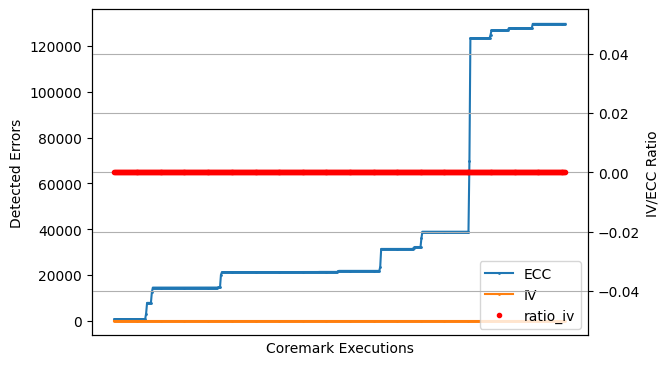

0.0 0.0


In [7]:

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

filtered_df = list_of_runs[0][list_of_runs[0]['timestamp'].dt.day == 6]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time > time(18,6)]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time < time(18,54)]
filtered_df = filtered_df[filtered_df['imem_se'] > 0]

log_print.plot_imem_iv(filtered_df)

filtered_df["ratio_iv"] = filtered_df["iv"] / filtered_df["imem_se"]
filtered_df.loc[(filtered_df["iv"] == 0) & (filtered_df["imem_se"] == 0), "ratio_iv"] = 1

mean_ratio_iv = round(filtered_df['ratio_iv'].mean(), 2)
std_ratio_iv = round(filtered_df['ratio_iv'].std(), 2)

print(mean_ratio_iv, std_ratio_iv)



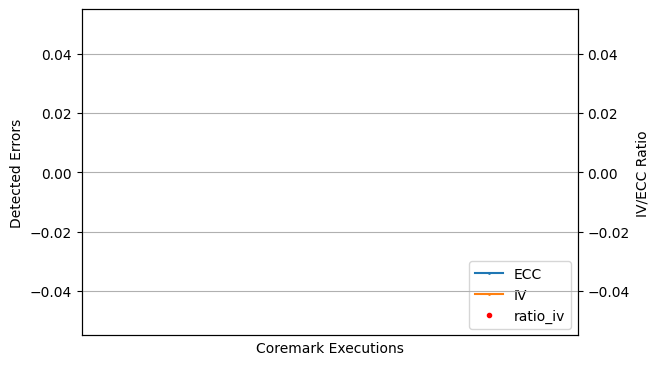

nan nan


In [8]:

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

filtered_df = list_of_runs[1]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time > time(22,56)]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time < time(2,17)]
filtered_df = filtered_df[filtered_df['imem_se'] > 0]

log_print.plot_imem_iv(filtered_df)

filtered_df["ratio_iv"] = filtered_df["iv"] / filtered_df["imem_se"]
filtered_df.loc[(filtered_df["iv"] == 0) & (filtered_df["imem_se"] == 0), "ratio_iv"] = 1

mean_ratio_iv = round(filtered_df['ratio_iv'].mean(), 2)
std_ratio_iv = round(filtered_df['ratio_iv'].std(), 2)

print(mean_ratio_iv, std_ratio_iv)



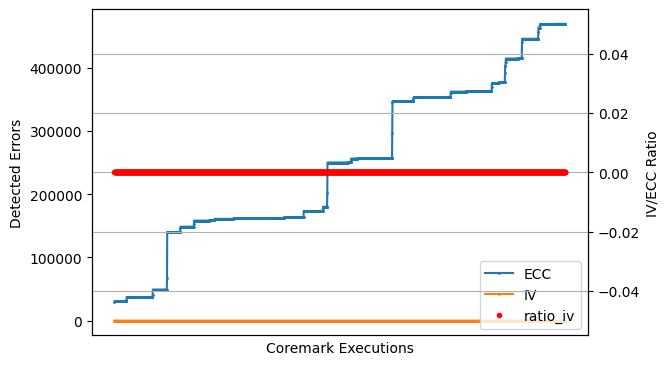

0.0 0.0


In [9]:

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

filtered_df = list_of_runs[2][list_of_runs[2]['timestamp'].dt.day == 7]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time > time(2,18)]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time < time(5,39)]
filtered_df = filtered_df[filtered_df['imem_se'] > 0]

log_print.plot_imem_iv(filtered_df)

filtered_df["ratio_iv"] = filtered_df["iv"] / filtered_df["imem_se"]
filtered_df.loc[(filtered_df["iv"] == 0) & (filtered_df["imem_se"] == 0), "ratio_iv"] = 1

mean_ratio_iv = round(filtered_df['ratio_iv'].mean(), 2)
std_ratio_iv = round(filtered_df['ratio_iv'].std(), 2)

print(mean_ratio_iv, std_ratio_iv)



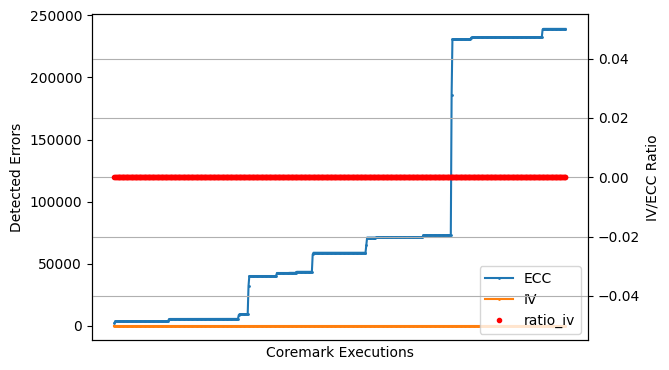

0.0 0.0


In [10]:

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

filtered_df = list_of_runs[3][list_of_runs[3]['timestamp'].dt.day == 7]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time > time(5,40)]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time < time(8,58)]
filtered_df = filtered_df[filtered_df['imem_se'] > 0]

log_print.plot_imem_iv(filtered_df)

filtered_df["ratio_iv"] = filtered_df["iv"] / filtered_df["imem_se"]
filtered_df.loc[(filtered_df["iv"] == 0) & (filtered_df["imem_se"] == 0), "ratio_iv"] = 1

mean_ratio_iv = round(filtered_df['ratio_iv'].mean(), 2)
std_ratio_iv = round(filtered_df['ratio_iv'].std(), 2)

print(mean_ratio_iv, std_ratio_iv)



In [11]:

# # Set display options to show all rows and columns
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# filtered_df = list_of_runs[4][list_of_runs[4]['timestamp'].dt.day == 8]
# filtered_df = filtered_df[filtered_df['timestamp'].dt.time > time(15,12)]
# filtered_df = filtered_df[filtered_df['timestamp'].dt.time < time(17,6)]
# filtered_df = filtered_df[filtered_df['imem_se'] > 0]

# log_print.plot_imem_iv(filtered_df)

# filtered_df["ratio_iv"] = filtered_df["iv"] / filtered_df["imem_se"]
# filtered_df.loc[(filtered_df["iv"] == 0) & (filtered_df["imem_se"] == 0), "ratio_iv"] = 1

# mean_ratio_iv = round(filtered_df['ratio_iv'].mean(), 2)
# std_ratio_iv = round(filtered_df['ratio_iv'].std(), 2)

# print(mean_ratio_iv, std_ratio_iv)

